In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

import numpy as np

from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.constants import GenParamTuple# candidate_environments_args["n_environments"] = 50


np.set_printoptions(linewidth=160, precision=2)

from src.utils.environment_design import EnvironmentDesign

## Make true environment

In [6]:
# 0. Setup
N, M = 7,7



# Start by making the agent we want to learn the parameters of
agent_gamma = np.array(0.75)
p_true= np.array(0.81)
big_reward_true = np.array(0.7)

agent_R = np.zeros((N, M))
agent_R[N-1, 0] = 0.1
agent_R[N-1, M-1] = big_reward_true
agent_R = agent_R.flatten()

goal_states = np.where(agent_R != 0)[0]


# wall_states = [14] #TODO: why do we need this
wall_states = []

T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)


#Define custom functions to generate reward, transition and gamma.
def custom_transition_func(p):

    _T = transition_matrix(N=7, M=7, p=p, absorbing_states=goal_states)
    _T = insert_walls_into_T(T=_T, wall_indices=wall_states)
    return _T

def custom_gamma_func(gamma):
    return gamma

def custom_reward_func(big_reward):
    reward_func = np.zeros((N, M))
    reward_func[N-1, 0] = 0.1
    reward_func[N-1, M-1] = big_reward
    return reward_func.flatten()


#Create parameter ranges
resolution = 20
p_range = np.linspace(0.5, 0.95, resolution)
gamma_range = np.linspace(0.5, 0.95, resolution)
R_range = np.linspace(0.3, 0.95, resolution)


gamma_range = gamma_range.reshape(1, resolution)
p_range = p_range.reshape(1, resolution)
R_range = R_range.reshape(1, resolution)

p_true = p_true.reshape(1, 1)
agent_gamma = agent_gamma.reshape(1, 1)
big_reward_true = big_reward_true.reshape(1, 1)



true_params = GenParamTuple(T = p_true, gamma=agent_gamma, R=big_reward_true)




big_small = Environment(
    N=N,
    M=M,
    reward_function = custom_reward_func,
    transition_function=custom_transition_func,
    gamma = custom_gamma_func,
    wall_states=wall_states,
    start_state=1,
    goal_states=goal_states
)

In [7]:
env_design = EnvironmentDesign(base_environment=big_small, 
                               user_params=true_params, 
                               learn_what = ["gamma", "T"],
                               parameter_ranges_R=R_range,
                               parameter_ranges_gamma=gamma_range,
                               parameter_ranges_T=p_range)

Generated parameter mesh of shape:  (20, 20)


In [8]:
candidate_environments_args = {}
candidate_environments_args["generate_how"] = "BIRL"
# candidate_environments_args["n_compute_BM"] = 100
# candidate_environments_args["n_iterations"] = 1
# candidate_environments_args["stepsize"] = 0.0005

# candidate_environments_args = {}
# candidate_environments_args["generate_how"] = "ED-BIRL"
# candidate_environments_args["n_environments"] = 1
# candidate_environments_args["n_walls"] = 5
# candidate_environments_args["how"] = "value"


env_design.run_n_episodes(n_episodes = 25,
                          candidate_environments_args=candidate_environments_args,
                          verbose=True)

/tmp/ipykernel_108008/1224284347.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_func[N-1, M-1] = big_reward


Started episode 0.
Finished episode 0.
Started episode 1.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7219849562527331, 0.7291553845140748]
Computed Region of Interest. Size = 0.75
Finished episode 1.
Started episode 2.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7064158860810086, 0.7497040404614782]
Computed Region of Interest. Size = 0.55
Finished episode 2.
Started episode 3.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6875527609647409, 0.7698755723710127]
Computed Region of Interest. Size = 0.41
Finished episode 3.
Started episode 4.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7050583901695873, 0.7930589010228666]
Computed Region of Interest. Size = 0.3
Finished episode 4.
St

In [11]:
env_design.all_observations

[(<src.utils.make_environment.Environment at 0x76ce862f2950>,
  [array([[ 0,  2,  7],
          [ 7,  3, 14],
          [14,  3, 21],
          [21,  0, 14],
          [14,  0, 14],
          [14,  1, 15],
          [15,  3, 22],
          [22,  3, 23],
          [23,  1, 24],
          [24,  1, 25],
          [25,  1, 26],
          [26,  1, 27],
          [27,  3, 34],
          [34,  3, 41],
          [41,  3, 48],
          [48, -1, -1]])]),
 (<src.utils.make_environment.Environment at 0x76ce862f2950>,
  [array([[ 0,  2,  0],
          [ 0,  1,  1],
          [ 1,  0,  0],
          [ 0,  2,  1],
          [ 1,  0,  0],
          [ 0,  3,  7],
          [ 7,  3, 14],
          [14,  1, 15],
          [15,  2,  8],
          [ 8,  0,  1],
          [ 1,  0,  0],
          [ 0,  3,  7],
          [ 7,  2,  0],
          [ 0,  1,  0],
          [ 0,  1,  1],
          [ 1,  0,  0],
          [ 0,  1,  1],
          [ 1,  1,  0],
          [ 0,  3,  1],
          [ 1,  3,  8],
        

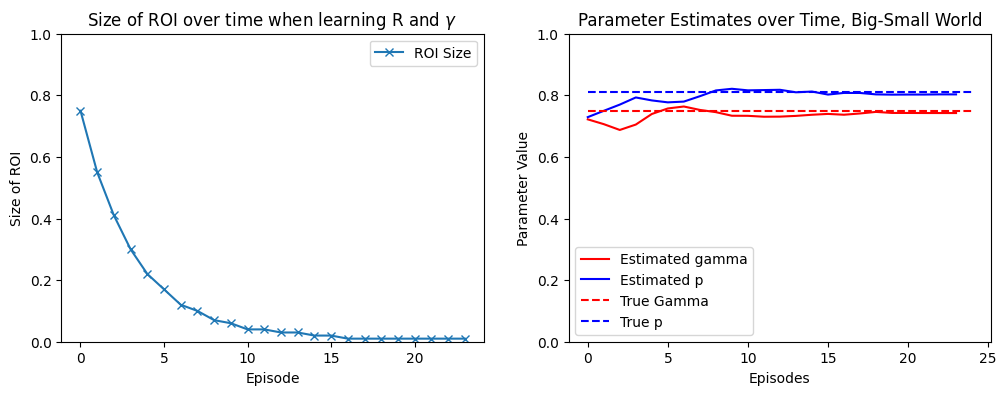

In [10]:
params = env_design.diagnostics["parameter_means"]
params = np.array(params)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

roi_sizes = env_design.diagnostics["ROI_sizes"]
roi_sizes = np.array(roi_sizes)
axs[0].plot(roi_sizes, "-x", label="ROI Size")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Size of ROI")
axs[0].set_ylim(0,1)
axs[0].legend()
axs[0].set_title("Size of ROI over time when learning R and $\gamma$")

axs[1].plot(params[:, 0], color="red", label="Estimated gamma")
axs[1].plot(params[:, 1], color="blue", label="Estimated p")
axs[1].hlines(true_params.gamma, 0, params.shape[0], color="red", linestyle="--", label="True Gamma")
axs[1].hlines(true_params.T, 0, params.shape[0], color="blue", linestyle="--", label="True p")
axs[1].set_ylim(0,1)
axs[1].set_title("Parameter Estimates over Time, Big-Small World")
axs[1].set_xlabel("Episodes")
axs[1].set_ylabel("Parameter Value")
axs[1].legend()

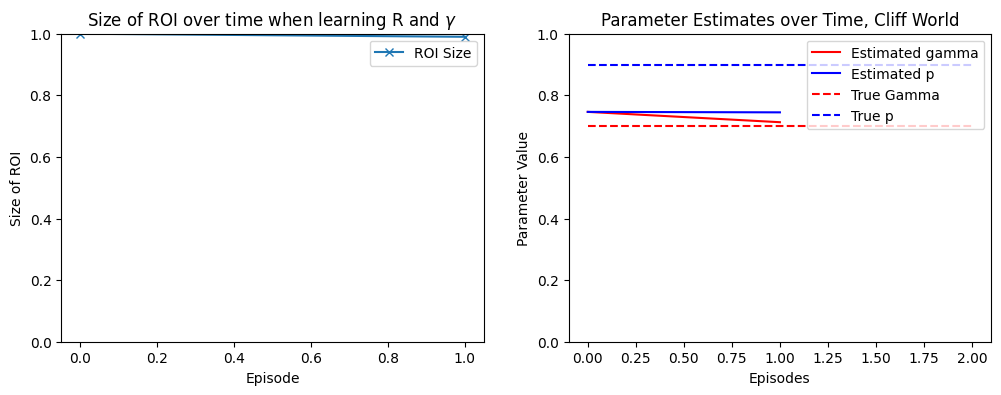

In [7]:
params = env_design.diagnostics["parameter_means"]
params = np.array(params)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

roi_sizes = env_design.diagnostics["ROI_sizes"]
roi_sizes = np.array(roi_sizes)
axs[0].plot(roi_sizes, "-x", label="ROI Size")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Size of ROI")
axs[0].set_ylim(0,1)
axs[0].legend()
axs[0].set_title("Size of ROI over time when learning R and $\gamma$")

axs[1].plot(params[:, 0], color="red", label="Estimated gamma")
axs[1].plot(params[:, 1], color="blue", label="Estimated p")
axs[1].hlines(true_params.gamma, 0, params.shape[0], color="red", linestyle="--", label="True Gamma")
axs[1].hlines(true_params.T, 0, params.shape[0], color="blue", linestyle="--", label="True p")
axs[1].set_ylim(0,1)
axs[1].set_title("Parameter Estimates over Time, Cliff World")
axs[1].set_xlabel("Episodes")
axs[1].set_ylabel("Parameter Value")
axs[1].legend()